# DEAM Dataset - Feed Forward Neural Network
## Essentia Best Overall Mean Featureset

## Import relevant libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torcheval.metrics import R2Score

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import math

import sys
sys.path.insert(1, '../../utils')
from paths import *

## Neural Network Training

### Import annotations dataset

In [2]:
df_annotations = pd.read_csv(get_deam_path('processed/annotations/deam_static_annotations.csv'))
df_annotations

,song_id,valence_mean_mapped,arousal_mean_mapped
0,2,-0.475,-0.500
1,3,-0.375,-0.425
2,4,0.175,0.125
3,5,-0.150,0.075
4,7,0.200,0.350
...,...,...,...
1739,1996,-0.275,0.225
1740,1997,0.075,-0.275
1741,1998,0.350,0.300
1742,1999,-0.100,0.100


### Import the featureset

This is where you should change between normalised and standardised, and untouched featuresets!

In [3]:
df_essentia_best_overall_features_mean = pd.read_csv(get_deam_path('processed/features/standardised_essentia_best_overall_features.csv'))

# drop Unnamed:0 column
df_essentia_best_overall_features_mean = df_essentia_best_overall_features_mean[df_essentia_best_overall_features_mean.columns[1:]]

df_essentia_best_overall_features_mean

,song_id,lowlevel.melbands_kurtosis.mean,lowlevel.melbands_skewness.mean,lowlevel.spectral_energy.mean,tonal.chords_strength.mean,tonal.hpcp_entropy.mean,tonal.key_edma.strength,tonal.key_temperley.strength,rhythm.beats_loudness_band_ratio.mean_0,rhythm.beats_loudness_band_ratio.mean_1,...,tonal.chords_histogram_14,tonal.chords_histogram_15,tonal.chords_histogram_16,tonal.chords_histogram_17,tonal.chords_histogram_18,tonal.chords_histogram_19,tonal.chords_histogram_20,tonal.chords_histogram_21,tonal.chords_histogram_22,tonal.chords_histogram_23
0,2,-0.058571,0.380991,-0.069127,-0.452484,0.809781,-0.085112,-0.288833,0.569221,-0.098158,...,0.231912,-0.169071,0.693755,-0.215917,0.174944,-0.382824,-0.398789,0.323740,-0.466431,-0.596685
1,3,1.479718,2.085477,3.025151,-0.386129,0.202518,0.233522,0.222782,2.000293,-0.968809,...,-0.220673,-0.312868,0.297680,-0.477019,-0.368661,-0.434446,-0.398789,-0.487958,-0.563641,-0.386679
2,4,-0.208423,0.235235,0.521816,1.264373,0.275493,-0.282729,-0.424737,1.035227,-0.435947,...,-0.220673,-0.292305,-0.231753,-0.477019,0.214373,-0.434446,-0.398789,-0.487958,-0.747808,-0.701512
3,5,-0.262338,-0.207226,-0.341279,1.199370,-0.827397,1.617190,1.568023,-0.764753,0.850362,...,-0.220673,-0.312868,-0.275872,-0.477019,-0.368661,0.004792,-0.398789,-0.439206,0.248861,-0.510704
4,7,2.154544,2.097370,2.747921,-1.793781,0.606843,-1.168573,-1.264489,2.137213,-1.194825,...,-0.220673,-0.312868,-0.275872,0.206820,-0.368661,0.998061,1.904098,0.729588,-0.747808,-0.568093
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1739,1996,-0.321333,-0.139660,0.382933,0.081083,0.775046,0.819838,0.782967,-0.920655,2.131480,...,-0.220673,-0.312868,-0.275872,-0.477019,-0.368661,-0.434446,-0.398789,-0.487958,-0.671897,-0.520047
1740,1997,-0.346532,-0.099817,0.297799,0.051395,0.428232,-0.546505,-0.387822,0.794940,-0.035303,...,-0.220673,-0.312868,-0.275872,-0.477019,-0.368661,-0.240465,-0.398789,0.878506,0.998161,1.772008
1741,1998,-0.242062,0.036691,-0.052204,0.025573,0.971682,0.513806,0.621963,0.807291,-0.616616,...,-0.220673,-0.065850,-0.275872,3.771523,-0.368661,2.682184,-0.398789,-0.487958,-0.444162,-0.701502
1742,1999,-0.098127,0.390945,-0.085379,-1.326377,0.769227,0.185179,0.364287,0.474512,0.050776,...,1.114688,-0.086435,4.781004,-0.427183,1.810241,0.044041,-0.398789,4.066921,0.043842,0.883837


In [4]:
df_essentia_best_overall_features_mean.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1744 entries, 0 to 1743
Data columns (total 38 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   song_id                                  1744 non-null   int64  
 1   lowlevel.melbands_kurtosis.mean          1744 non-null   float64
 2   lowlevel.melbands_skewness.mean          1744 non-null   float64
 3   lowlevel.spectral_energy.mean            1744 non-null   float64
 4   tonal.chords_strength.mean               1744 non-null   float64
 5   tonal.hpcp_entropy.mean                  1744 non-null   float64
 6   tonal.key_edma.strength                  1744 non-null   float64
 7   tonal.key_temperley.strength             1744 non-null   float64
 8   rhythm.beats_loudness_band_ratio.mean_0  1744 non-null   float64
 9   rhythm.beats_loudness_band_ratio.mean_1  1744 non-null   float64
 10  rhythm.beats_loudness_band_ratio.mean_2  1744 no

Join both the featureset and annotation set together

In [5]:
df_essentia_best_overall_features_mean_whole = pd.merge(df_essentia_best_overall_features_mean, df_annotations, how='inner', on='song_id')
df_essentia_best_overall_features_mean_whole = df_essentia_best_overall_features_mean_whole.drop('song_id', axis=1)
df_essentia_best_overall_features_mean_whole

,lowlevel.melbands_kurtosis.mean,lowlevel.melbands_skewness.mean,lowlevel.spectral_energy.mean,tonal.chords_strength.mean,tonal.hpcp_entropy.mean,tonal.key_edma.strength,tonal.key_temperley.strength,rhythm.beats_loudness_band_ratio.mean_0,rhythm.beats_loudness_band_ratio.mean_1,rhythm.beats_loudness_band_ratio.mean_2,...,tonal.chords_histogram_16,tonal.chords_histogram_17,tonal.chords_histogram_18,tonal.chords_histogram_19,tonal.chords_histogram_20,tonal.chords_histogram_21,tonal.chords_histogram_22,tonal.chords_histogram_23,valence_mean_mapped,arousal_mean_mapped
0,-0.058571,0.380991,-0.069127,-0.452484,0.809781,-0.085112,-0.288833,0.569221,-0.098158,-0.312716,...,0.693755,-0.215917,0.174944,-0.382824,-0.398789,0.323740,-0.466431,-0.596685,-0.475,-0.500
1,1.479718,2.085477,3.025151,-0.386129,0.202518,0.233522,0.222782,2.000293,-0.968809,-1.278967,...,0.297680,-0.477019,-0.368661,-0.434446,-0.398789,-0.487958,-0.563641,-0.386679,-0.375,-0.425
2,-0.208423,0.235235,0.521816,1.264373,0.275493,-0.282729,-0.424737,1.035227,-0.435947,-0.816900,...,-0.231753,-0.477019,0.214373,-0.434446,-0.398789,-0.487958,-0.747808,-0.701512,0.175,0.125
3,-0.262338,-0.207226,-0.341279,1.199370,-0.827397,1.617190,1.568023,-0.764753,0.850362,0.883425,...,-0.275872,-0.477019,-0.368661,0.004792,-0.398789,-0.439206,0.248861,-0.510704,-0.150,0.075
4,2.154544,2.097370,2.747921,-1.793781,0.606843,-1.168573,-1.264489,2.137213,-1.194825,-1.209289,...,-0.275872,0.206820,-0.368661,0.998061,1.904098,0.729588,-0.747808,-0.568093,0.200,0.350
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1739,-0.321333,-0.139660,0.382933,0.081083,0.775046,0.819838,0.782967,-0.920655,2.131480,-0.013774,...,-0.275872,-0.477019,-0.368661,-0.434446,-0.398789,-0.487958,-0.671897,-0.520047,-0.275,0.225
1740,-0.346532,-0.099817,0.297799,0.051395,0.428232,-0.546505,-0.387822,0.794940,-0.035303,-0.473535,...,-0.275872,-0.477019,-0.368661,-0.240465,-0.398789,0.878506,0.998161,1.772008,0.075,-0.275
1741,-0.242062,0.036691,-0.052204,0.025573,0.971682,0.513806,0.621963,0.807291,-0.616616,-0.307099,...,-0.275872,3.771523,-0.368661,2.682184,-0.398789,-0.487958,-0.444162,-0.701502,0.350,0.300
1742,-0.098127,0.390945,-0.085379,-1.326377,0.769227,0.185179,0.364287,0.474512,0.050776,-0.278295,...,4.781004,-0.427183,1.810241,0.044041,-0.398789,4.066921,0.043842,0.883837,-0.100,0.100


#### Prepare dataframes for the neural network

Perform splitting of the dataframe into training and testing sets

In [6]:
features = df_essentia_best_overall_features_mean.drop('song_id', axis=1)
features

,lowlevel.melbands_kurtosis.mean,lowlevel.melbands_skewness.mean,lowlevel.spectral_energy.mean,tonal.chords_strength.mean,tonal.hpcp_entropy.mean,tonal.key_edma.strength,tonal.key_temperley.strength,rhythm.beats_loudness_band_ratio.mean_0,rhythm.beats_loudness_band_ratio.mean_1,rhythm.beats_loudness_band_ratio.mean_2,...,tonal.chords_histogram_14,tonal.chords_histogram_15,tonal.chords_histogram_16,tonal.chords_histogram_17,tonal.chords_histogram_18,tonal.chords_histogram_19,tonal.chords_histogram_20,tonal.chords_histogram_21,tonal.chords_histogram_22,tonal.chords_histogram_23
0,-0.058571,0.380991,-0.069127,-0.452484,0.809781,-0.085112,-0.288833,0.569221,-0.098158,-0.312716,...,0.231912,-0.169071,0.693755,-0.215917,0.174944,-0.382824,-0.398789,0.323740,-0.466431,-0.596685
1,1.479718,2.085477,3.025151,-0.386129,0.202518,0.233522,0.222782,2.000293,-0.968809,-1.278967,...,-0.220673,-0.312868,0.297680,-0.477019,-0.368661,-0.434446,-0.398789,-0.487958,-0.563641,-0.386679
2,-0.208423,0.235235,0.521816,1.264373,0.275493,-0.282729,-0.424737,1.035227,-0.435947,-0.816900,...,-0.220673,-0.292305,-0.231753,-0.477019,0.214373,-0.434446,-0.398789,-0.487958,-0.747808,-0.701512
3,-0.262338,-0.207226,-0.341279,1.199370,-0.827397,1.617190,1.568023,-0.764753,0.850362,0.883425,...,-0.220673,-0.312868,-0.275872,-0.477019,-0.368661,0.004792,-0.398789,-0.439206,0.248861,-0.510704
4,2.154544,2.097370,2.747921,-1.793781,0.606843,-1.168573,-1.264489,2.137213,-1.194825,-1.209289,...,-0.220673,-0.312868,-0.275872,0.206820,-0.368661,0.998061,1.904098,0.729588,-0.747808,-0.568093
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1739,-0.321333,-0.139660,0.382933,0.081083,0.775046,0.819838,0.782967,-0.920655,2.131480,-0.013774,...,-0.220673,-0.312868,-0.275872,-0.477019,-0.368661,-0.434446,-0.398789,-0.487958,-0.671897,-0.520047
1740,-0.346532,-0.099817,0.297799,0.051395,0.428232,-0.546505,-0.387822,0.794940,-0.035303,-0.473535,...,-0.220673,-0.312868,-0.275872,-0.477019,-0.368661,-0.240465,-0.398789,0.878506,0.998161,1.772008
1741,-0.242062,0.036691,-0.052204,0.025573,0.971682,0.513806,0.621963,0.807291,-0.616616,-0.307099,...,-0.220673,-0.065850,-0.275872,3.771523,-0.368661,2.682184,-0.398789,-0.487958,-0.444162,-0.701502
1742,-0.098127,0.390945,-0.085379,-1.326377,0.769227,0.185179,0.364287,0.474512,0.050776,-0.278295,...,1.114688,-0.086435,4.781004,-0.427183,1.810241,0.044041,-0.398789,4.066921,0.043842,0.883837


In [7]:
targets = df_annotations.drop('song_id', axis=1)
targets

,valence_mean_mapped,arousal_mean_mapped
0,-0.475,-0.500
1,-0.375,-0.425
2,0.175,0.125
3,-0.150,0.075
4,0.200,0.350
...,...,...
1739,-0.275,0.225
1740,0.075,-0.275
1741,0.350,0.300
1742,-0.100,0.100


Perform 80-20 train-test split

In [8]:
X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=0.2, random_state=42)

Create tensors for X_train and X_test

In [9]:
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float64)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float64)

Create tensors for Y_train and Y_test

In [10]:
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float64)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float64)

Define neural network parameters and instantitate neural network

In [11]:
input_size = 1
hidden_size = 20 
output_size = 2  # Output size for valence and arousal
learning_rate = 0.001
criterion = nn.MSELoss()

In [12]:
num_epochs = 164

Set a random seed to ensure consistent initial weights of the neural network

In [13]:
# Set the seed
seed = 42
torch.manual_seed(seed)

Define the neural network

In [14]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_size):
        super(NeuralNetwork, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), 2)
        )

    def forward(self, x):
        return self.layers(x)

#### Training

Prepare input_train_data and target_train_labels

In [15]:
input_train_data = X_train_tensor.float()

# input_train_data = input_train_data.view(input_train_data.shape[1], -1)
print(input_train_data.shape)

target_train_labels = y_train_tensor

torch.Size([1395, 37])


Training loop

In [16]:
def train_model(num_epochs):
  model = NeuralNetwork(input_size=input_train_data.shape[1])
  optimiser = optim.Adam(model.parameters(), lr=learning_rate)
  
  for epoch in range(num_epochs):
    optimiser.zero_grad()
    
    # forward pass
    output = model(input_train_data)

    # calculate loss
    loss = torch.sqrt(criterion(output.float(), target_train_labels.float()))

    # backward pass
    loss.backward()
    # update weights
    optimiser.step()

    print(f'Epoch {epoch + 1}, Loss: {math.sqrt(loss.item())}')

  print("Training completed.")
  return model

In [17]:
model = train_model(num_epochs)

Epoch 1, Loss: 0.6117395351186724
Epoch 2, Loss: 0.6100289674822418
Epoch 3, Loss: 0.6083395548288977
Epoch 4, Loss: 0.606698049564977
Epoch 5, Loss: 0.605190631609765
Epoch 6, Loss: 0.6036950002224712
Epoch 7, Loss: 0.6022123072156196
Epoch 8, Loss: 0.6007437645933451
Epoch 9, Loss: 0.5992894017869131
Epoch 10, Loss: 0.597849023184856
Epoch 11, Loss: 0.5964229549619942
Epoch 12, Loss: 0.59539822138981
Epoch 13, Loss: 0.5943946851966364
Epoch 14, Loss: 0.5933733548594994
Epoch 15, Loss: 0.5923438990458686
Epoch 16, Loss: 0.5913118949816885
Epoch 17, Loss: 0.5902809392308364
Epoch 18, Loss: 0.5892537937147383
Epoch 19, Loss: 0.5882323783037903
Epoch 20, Loss: 0.5872183469554043
Epoch 21, Loss: 0.5862129581193154
Epoch 22, Loss: 0.5852172239186628
Epoch 23, Loss: 0.5842319843908202
Epoch 24, Loss: 0.583258008067213
Epoch 25, Loss: 0.5822958632734793
Epoch 26, Loss: 0.5813460957656645
Epoch 27, Loss: 0.5804091257352615
Epoch 28, Loss: 0.5794852466894013
Epoch 29, Loss: 0.5785748303992896


## Neural Network Testing

Prepare input_test_data and target_test_labels

In [18]:
input_test_data = X_test_tensor.float()

# input_test_data = input_test_data.view(input_test_data.shape[1], -1)
print(input_test_data.shape)

target_test_labels = y_test_tensor

torch.Size([349, 37])


Generating scores

In [19]:
def test_model(trained_model):
  with torch.no_grad():
    test_pred = trained_model(input_test_data)
    test_loss = criterion(test_pred.float(), target_test_labels)

    # Separate the output into valence and arousal
    valence_pred = test_pred[:, 0]
    arousal_pred = test_pred[:, 1]
        
    valence_target = target_test_labels[:, 0]
    arousal_target = target_test_labels[:, 1]

     # Calculate RMSE for valence and arousal separately
    valence_rmse = math.sqrt(mean_squared_error(valence_pred, valence_target))
    arousal_rmse = math.sqrt(mean_squared_error(arousal_pred, arousal_target))

  rmse = math.sqrt(test_loss.item())
  print(f'Test RMSE: {rmse}')

  print(f'Valence RMSE: {valence_rmse}')
  print(f'Arousal RMSE: {arousal_rmse}')

  metric = R2Score(multioutput="raw_values")
  metric.update(test_pred, target_test_labels)
  adjusted_r2_score = metric.compute()
  print(f'Test R^2 score: {adjusted_r2_score}')

  metric = R2Score(multioutput="raw_values", num_regressors=input_test_data.shape[1])
  metric.update(test_pred, target_test_labels)
  adjusted_r2_score = metric.compute()
  print(f'Test Adjusted R^2 score: {adjusted_r2_score}')

  metric = R2Score()
  metric.update(test_pred, target_test_labels)
  r2_score = metric.compute()
  print(f'Test R^2 score (overall): {r2_score}')
  return test_pred, rmse, adjusted_r2_score, r2_score

In [20]:
test_pred, rmse, adjusted_r2_score, r2_score = test_model(model)

Test RMSE: 0.2612383610913183
Valence RMSE: 0.24607732401040297
Arousal RMSE: 0.2755665313844103
Test R^2 score: tensor([0.2661, 0.2481], dtype=torch.float64)
Test Adjusted R^2 score: tensor([0.1788, 0.1586], dtype=torch.float64)
Test R^2 score (overall): 0.2571213472447835


In [22]:
torch.save(model.state_dict(), '../../models/deam_feedforward_nn_essentia_best_overall_mean_standardised.pt')

True values (test set)

In [22]:
target_test_labels

tensor([[-0.1500, -0.1500],
        [-0.3000, -0.1000],
        [ 0.2000,  0.3500],
        [ 0.2250,  0.4500],
        [-0.1750, -0.2000],
        [-0.5250, -0.3000],
        [-0.2500, -0.7750],
        [ 0.3000,  0.3000],
        [-0.1750, -0.4000],
        [ 0.4500,  0.1500],
        [ 0.1750,  0.0250],
        [-0.1750, -0.0250],
        [-0.0500, -0.3000],
        [ 0.1250,  0.3000],
        [-0.0750, -0.1500],
        [-0.2000, -0.2750],
        [-0.6000, -0.2250],
        [ 0.1500, -0.2000],
        [ 0.2750,  0.6000],
        [-0.1500, -0.4500],
        [-0.2250, -0.6250],
        [-0.0250, -0.4500],
        [-0.5250, -0.1250],
        [ 0.0000,  0.3250],
        [ 0.1250,  0.3750],
        [ 0.1500, -0.2500],
        [ 0.4500,  0.3250],
        [ 0.2500,  0.2250],
        [-0.1000,  0.0750],
        [ 0.4250,  0.1250],
        [-0.4500, -0.3500],
        [-0.0500,  0.3750],
        [-0.4750, -0.2000],
        [-0.2750, -0.4000],
        [-0.4000, -0.2250],
        [ 0.1000, -0

Predicted values

In [23]:
test_pred

tensor([[ 0.1671,  0.1682],
        [-0.2498, -0.3022],
        [-0.1794, -0.2300],
        [ 0.1664,  0.1672],
        [-0.2510, -0.3032],
        [-0.2976, -0.3492],
        [-0.4330, -0.4802],
        [ 0.1669,  0.1691],
        [-0.0569, -0.0996],
        [ 0.1674,  0.1695],
        [ 0.1675,  0.1691],
        [-0.1709, -0.2213],
        [-0.3711, -0.4203],
        [ 0.1668,  0.1677],
        [ 0.1667,  0.1676],
        [ 0.1674,  0.1689],
        [-0.2965, -0.3482],
        [ 0.1675,  0.1693],
        [ 0.1664,  0.1672],
        [-0.2207, -0.2722],
        [-0.2399, -0.2919],
        [-0.2020, -0.2530],
        [-0.2398, -0.2919],
        [ 0.1669,  0.1679],
        [-0.1417, -0.1915],
        [-0.1503, -0.2002],
        [ 0.1667,  0.1675],
        [ 0.0445,  0.0304],
        [ 0.1651,  0.1658],
        [ 0.1671,  0.1682],
        [-0.2767, -0.3290],
        [ 0.1671,  0.1681],
        [ 0.1123,  0.1101],
        [ 0.1675,  0.1695],
        [-0.3936, -0.4421],
        [ 0.1002,  0

In [24]:
pred_valence = test_pred[:, 0]
pred_arousal = test_pred[1]
real_valence = target_test_labels[0]
real_arousal = target_test_labels[1]


metric = R2Score(multioutput='raw_values')
metric.update(test_pred, target_test_labels)
print(metric.compute())

tensor([0.2077, 0.1178], dtype=torch.float64)


## Analyse relationship between epochs and r^2 score

Create lists to store the epochs and R^2 scores

In [25]:
num_epochs_list = [i for i in range(1, 301)]
adjusted_r2_scores_valence_list = []
adjusted_r2_scores_arousal_list = []
r2_scores_list = []
rmse_list = []

Conduct training and testing for each num_epochs

In [26]:
for num_epochs in num_epochs_list:
  # Set the seed
  torch.manual_seed(seed)

  print(f'Num of epochs: {num_epochs}')
  
  model = train_model(num_epochs)

  print("Training completed.")
  print("Testing model...")

  test_pred, rmse, adjusted_r2_score, r2_score = test_model(model)
  adjusted_r2_scores_valence_list.append(adjusted_r2_score[0])
  adjusted_r2_scores_arousal_list.append(adjusted_r2_score[1])
  r2_scores_list.append(r2_score)
  rmse_list.append(rmse)

print("Completed.")

Num of epochs: 1
Epoch 1, Loss: 0.6117395351186724
Training completed.
Training completed.
Testing model...
Test RMSE: 0.3770084412793108
Valence RMSE: 0.4223478050931573
Arousal RMSE: 0.3254121404076737
Test R^2 score: tensor([-1.1618, -0.0485], dtype=torch.float64)
Test Adjusted R^2 score: tensor([-1.4189, -0.1733], dtype=torch.float64)
Test R^2 score (overall): -0.6051387348535369
Num of epochs: 2
Epoch 1, Loss: 0.6117395351186724
Epoch 2, Loss: 0.6100289674822418
Training completed.
Training completed.
Testing model...
Test RMSE: 0.37479346241247913
Valence RMSE: 0.41863576960085513
Arousal RMSE: 0.32509132769879995
Test R^2 score: tensor([-1.1239, -0.0465], dtype=torch.float64)
Test Adjusted R^2 score: tensor([-1.3766, -0.1710], dtype=torch.float64)
Test R^2 score (overall): -0.5851892413055466
Num of epochs: 3
Epoch 1, Loss: 0.6117395351186724
Epoch 2, Loss: 0.6100289674822418
Epoch 3, Loss: 0.6083395548288977
Training completed.
Training completed.
Testing model...
Test RMSE: 0.

### Plot graphs to visualise relationship between the evaluation metrics

Import relevant libraries

In [27]:
import matplotlib.pyplot as plt

#### RMSE vs. num_epochs

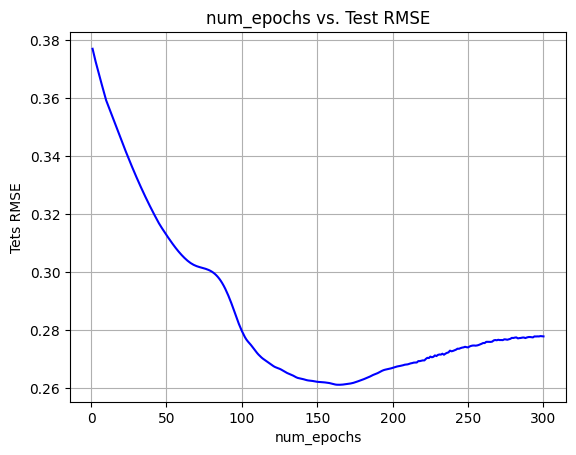

In [28]:
plt.plot(num_epochs_list, rmse_list, color='b', linestyle='-')
plt.title('num_epochs vs. Test RMSE')
plt.xlabel('num_epochs')
plt.ylabel('Tets RMSE') 
plt.grid(True)
plt.show() 

In [29]:
min_rmse = min(rmse_list)
corresponding_r2_score = r2_scores_list[rmse_list.index(min_rmse)]
corresponding_num_epochs = num_epochs_list[rmse_list.index(min_rmse)]

print(f'Min RMSE score: {min_rmse}')
print(f'Corresponding R^2 SCore: {corresponding_r2_score}')
print(f'Corresponding num_epochs: {corresponding_num_epochs}')

Min RMSE score: 0.2612383610913183
Corresponding R^2 SCore: 0.2571213472447835
Corresponding num_epochs: 164


#### Test R^2 Score vs. num_epochs

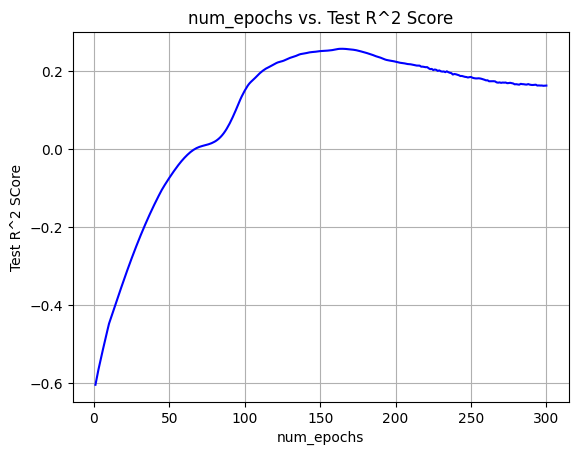

In [30]:
plt.plot(num_epochs_list, r2_scores_list, color='b', linestyle='-')
plt.title('num_epochs vs. Test R^2 Score')
plt.xlabel('num_epochs')
plt.ylabel('Test R^2 SCore') 
plt.grid(True)
plt.show() 

In [31]:
max_r2_score = max(r2_scores_list)
corresponding_rmse = rmse_list[r2_scores_list.index(max_r2_score)]
corresponding_num_epochs = num_epochs_list[r2_scores_list.index(max_r2_score)]

print(f'Max R^2 score: {max_r2_score}')
print(f'Corresponding RMSE: {corresponding_rmse}')
print(f'Corresponding num_epochs: {corresponding_num_epochs}')

Max R^2 score: 0.2571213472447835
Corresponding RMSE: 0.2612383610913183
Corresponding num_epochs: 164


#### Test Adjusted R^2 Score (Valence) vs. num_epochs

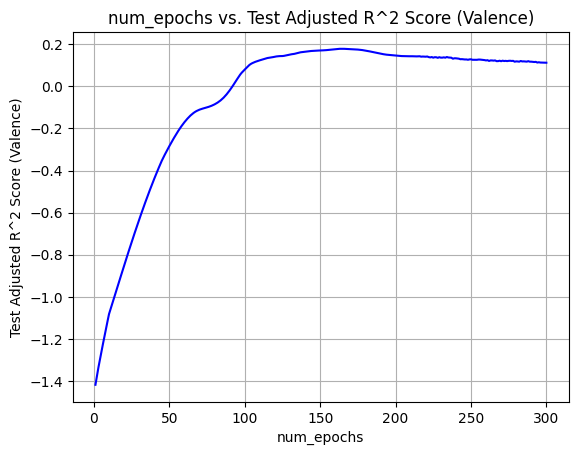

In [32]:
plt.plot(num_epochs_list, adjusted_r2_scores_valence_list, color='b', linestyle='-')
plt.title('num_epochs vs. Test Adjusted R^2 Score (Valence)')
plt.xlabel('num_epochs')
plt.ylabel('Test Adjusted R^2 Score (Valence)') 
plt.grid(True)
plt.show() 

In [33]:
max_r2_score_valence = max(adjusted_r2_scores_valence_list)
corresponding_rmse = rmse_list[adjusted_r2_scores_valence_list.index(max_r2_score_valence)]
corresponding_num_epochs = num_epochs_list[adjusted_r2_scores_valence_list.index(max_r2_score_valence)]

print(f'Max R^2 score: {max_r2_score_valence}')
print(f'Corresponding RMSE: {corresponding_rmse}')
print(f'Corresponding num_epochs: {corresponding_num_epochs}')

Max R^2 score: 0.17883829347754054
Corresponding RMSE: 0.2612383610913183
Corresponding num_epochs: 164


#### Test Adjusted R^2 Score (Arousal) vs. num_epochs

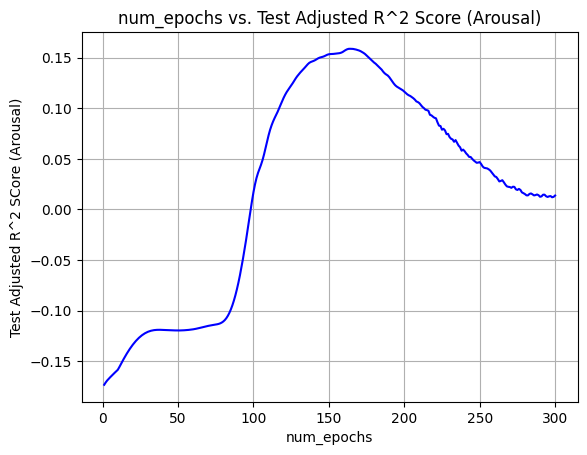

In [34]:
plt.plot(num_epochs_list, adjusted_r2_scores_arousal_list, color='b', linestyle='-')
plt.title('num_epochs vs. Test Adjusted R^2 Score (Arousal)')
plt.xlabel('num_epochs')
plt.ylabel('Test Adjusted R^2 SCore (Arousal)') 
plt.grid(True)
plt.show() 

In [35]:
max_r2_score_arousal = max(adjusted_r2_scores_arousal_list)
corresponding_rmse = rmse_list[adjusted_r2_scores_arousal_list.index(max_r2_score_arousal)]
corresponding_num_epochs = num_epochs_list[adjusted_r2_scores_arousal_list.index(max_r2_score_arousal)]

print(f'Max R^2 score: {max_r2_score_arousal}')
print(f'Corresponding RMSE: {corresponding_rmse}')
print(f'Corresponding num_epochs: {corresponding_num_epochs}')

Max R^2 score: 0.1586422778484058
Corresponding RMSE: 0.2612383610913183
Corresponding num_epochs: 164
